In [1]:
from astropy.io import fits 
from astropy import constants
from astropy.timeseries import BoxLeastSquares 
from astroquery.mast import Catalogs
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.signal import lombscargle
from scipy.optimize import minimize
from lightkurve import search_lightcurve


In [2]:
def fetch_and_normalize_kepler_data(target):
    # Search for light curves for the target across all quarters
    search_result = search_lightcurve(target, mission="Kepler")
    lc_collection = search_result.download_all()
    
    # Initialize empty arrays for time, flux, and error
    time, flux, error = np.array([]), np.array([]), np.array([])
    
    # Iterate through the downloaded light curves
    for lc in lc_collection:
        lc_data = lc.normalize().remove_nans()  # Normalize and remove NaNs

        # Temporary variables to add on to array later.
        tmptime = lc_data.time.value
        tmpflux = lc_data.flux.value
        tmperror = lc_data.flux_err.value
        
        array_size = len(tmpflux)
        window_length = min(501, array_size - (array_size % 2 == 0))  # Ensure odd window_length
        
        if window_length > 2:  # Apply filter only if there is enough data
            interp_savgol = savgol_filter(tmpflux, window_length=window_length, polyorder=3)
        else:
            interp_savgol = np.ones_like(tmpflux)  
        
        # Append the data to the arrays.
        time = np.append(time, tmptime)
        flux = np.append(flux, tmpflux / interp_savgol)
        error = np.append(error, tmperror )
    
    # Initialise the dataframe.
    df = pd.DataFrame(
        {
            "time": time,
            "flux": flux,
            "error": error,
        }
    )
    
    # Filter the data.
    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    df = df[(df["flux"] <= mean_flux + 2 * std_flux) & (df["flux"] >= mean_flux - 8 * std_flux)]
    
    return df


In [3]:
target = "Kepler-11" 
kepler_dataframe = fetch_and_normalize_kepler_data(target)

In [4]:
def find_transits(x, y):
    freqs = np.linspace(1/(x.iloc[-1] - x.iloc[0]), 1/(x.iloc[1] - x.iloc[0]), 15000)
    lomb = scipy.signal.lombscargle(x, y, freqs, precenter=True)
    
    period = np.linspace(1, 150, 10000)
    lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)
    
    return period, lomb2

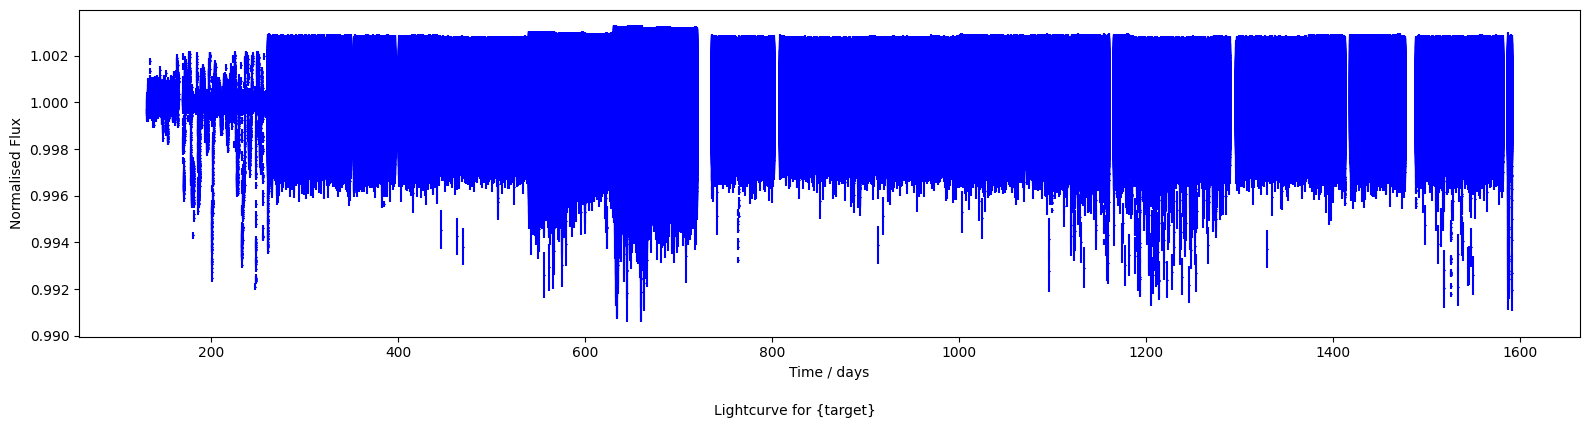

In [5]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)

ax.errorbar(kepler_dataframe["time"], kepler_dataframe["flux"], kepler_dataframe["error"], marker='x', markersize=1, ls="None", color="blue")
ax.set_ylabel("Normalised Flux")
ax.set_xlabel("Time / days")

fig.text(0.5, -0.05, "Lightcurve for {target}", ha="center")

plt.tight_layout()
plt.show()
plt.close()

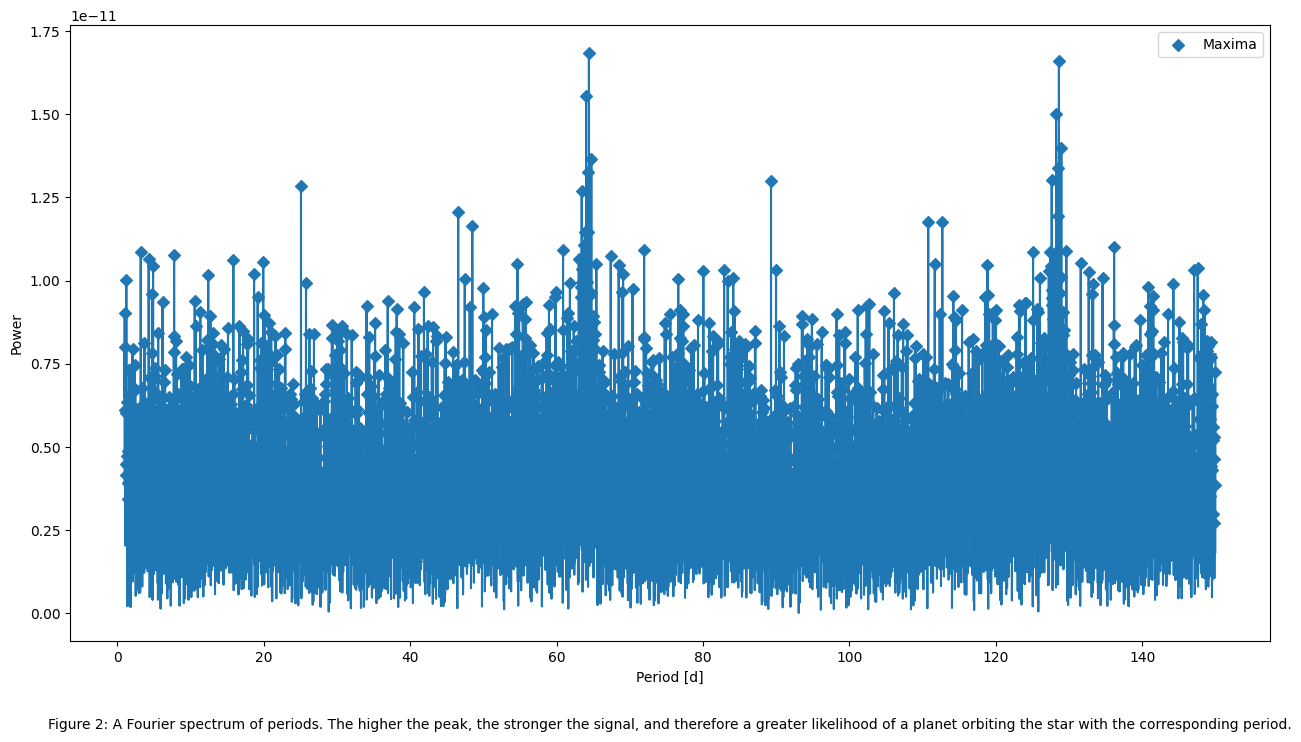

In [6]:
# Produce Fourier spectrum, accounting for aliasing
period, lomb2 = find_transits(kepler_dataframe["time"], kepler_dataframe["flux"])
peaks = scipy.signal.find_peaks(lomb2, height=(0.75e-12))
height = peaks[1]["peak_heights"]
peak_pos = period[peaks[0]]

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.plot(period, lomb2)
ax.scatter(peak_pos, height, marker="D", label="Maxima")
ax.set_xlabel('Period [d]')
ax.set_ylabel('Power')

fig.text(0.5, 0, "Figure 2: A Fourier spectrum of periods. The higher the peak, the stronger the signal, and therefore a greater likelihood of a planet orbiting the star with the corresponding period.", ha="center")
plt.subplots_adjust(left=0.1)
# plt.tight_layout()
plt.legend()
plt.show()
plt.close()

In [7]:
def iterative_bls_search(time, flux, error, max_iterations=5, min_period=0.5, max_period=100, duration_range=(0.01, 0.1)):
    """
    Perform iterative BLS search to detect multiple planets.
    """
    results_list = []
    residual_flux = flux.copy()
    
    for i in range(max_iterations):
        # Run BLS analysis
        results, peak_periods, peak_powers, best_period, best_transit_model = run_bls_analysis(
            time, residual_flux, error, min_period=min_period, max_period=max_period, duration_range=duration_range
        )
        
        if len(peak_periods) == 0 or max(results.power) < 0.01:
            print(f"No significant signal detected in iteration {i+1}.")
            break
        
        # Store the results for the current planet
        results_list.append({
            "period": best_period,
            "power": max(results.power),
            "duration": results.duration[np.argmax(results.power)],
            "depth": results.depth[np.argmax(results.power)],
            "transit_model": best_transit_model
        })
        
        # Subtract the best-fit transit model from the residual flux
        residual_flux -= best_transit_model
        print(f"Iteration {i+1}: Detected planet with period = {best_period:.2f} days.")
    
    return results_list


In [ ]:
def run_bls_analysis(time, flux, error, min_period=0.5, max_period=100, duration_range=(0.01, 0.1)):
    """
    Perform Box Least Squares transit search.
    """
    # Define BLS model
    model = BoxLeastSquares(time, flux, dy=error)
    
    # Define period and duration grid
    periods = np.linspace(min_period, max_period, 10000)
    durations = duration_range  # Duration range in days
    
    # Perform BLS search
    results = model.power(periods, durations)
    
    # Find peaks in the BLS power spectrum
    peaks = scipy.signal.find_peaks(results.power, height=0.01)
    peak_periods = periods[peaks[0]]
    peak_powers = results.power[peaks[0]]
    
    # Best candidate transit
    best_period = results.period[np.argmax(results.power)]
    best_transit_model = model.model(time, best_period, results.duration[np.argmax(results.power)], results.depth[np.argmax(results.power)])
    
    return results, peak_periods, peak_powers, best_period, best_transit_model


In [ ]:
# Iterate over detected peaks to analyze each candidate period
def analyze_peaks_with_bls(time, flux, error, peak_periods, duration_range=(0.01, 0.1)):
    results_list = []
    for period in peak_periods:
        print(f"Analyzing candidate period: {period:.2f} days")
        
        # Run BLS analysis near this period
        results, _, _, best_period, best_transit_model = run_bls_analysis(
            time,
            flux,
            error,
            min_period=period * 0.9,  # Narrow search around the candidate period
            max_period=period * 1.1,
            duration_range=duration_range
        )
        
        if best_period is not None:
            results_list.append({
                "candidate_period": period,
                "refined_period": best_period,
                "transit_model": best_transit_model,
                "power": max(results.power),
                "duration": results.duration[np.argmax(results.power)],
                "depth": results.depth[np.argmax(results.power)],
            })
    
    return results_list

In [8]:
def plot_bls_results(results, peak_periods, peak_powers, time, flux, best_transit_model):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Plot BLS power spectrum
    axes[0].plot(results.period, results.power, label="BLS Power Spectrum")
    axes[0].scatter(peak_periods, peak_powers, color='red', label="Detected Peaks")
    axes[0].set_xscale("log")
    axes[0].set_xlabel("Period (days)")
    axes[0].set_ylabel("Power")
    axes[0].legend()
    axes[0].set_title("BLS Periodogram")

    # Phase-folded light curve
    phase = (time % results.period[np.argmax(results.power)]) / results.period[np.argmax(results.power)]
    axes[1].scatter(phase, flux, s=1, label="Flux")
    axes[1].plot(phase, best_transit_model, color="red", label="Best-fit Model")
    axes[1].set_xlabel("Phase")
    axes[1].set_ylabel("Flux")
    axes[1].legend()
    axes[1].set_title("Phase-folded Light Curve")

    plt.tight_layout()
    plt.show()


In [9]:
def fetch_stellar_info(target):
    catalog_data = Catalogs.query_object(target, catalog="TIC")
    if len(catalog_data) > 0:
        star_data = catalog_data[0]
        stellar_params = {
            "stellar_radius": star_data["rad"],  # Stellar radius in solar radii
            "stellar_mass": star_data["mass"],  # Stellar mass in solar masses
            "temperature": star_data["Teff"],   # Stellar effective temperature
            "log_g": star_data["logg"],        # Surface gravity
        }
        return stellar_params
    else:
        return None

In [10]:
def estimate_planet_radius(transit_depth, stellar_radius):

    planet_radius = np.sqrt(transit_depth) * stellar_radius  # Assuming solar units
    return planet_radius


In [11]:
def summarize_planets(results_list, stellar_radius):
    """
    Print a summary of detected planets and their parameters.
    """
    print("\nSummary of Detected Planets:")
    print("-" * 40)
    for i, result in enumerate(results_list):
        period = result["period"]
        depth = result["depth"]
        duration = result["duration"]
        radius = estimate_planet_radius(depth, stellar_radius)
        print(f"Planet {i+1}:")
        print(f"  Orbital Period = {period:.2f} days")
        print(f"  Transit Depth = {depth:.2e}")
        print(f"  Transit Duration = {duration:.2f} days")
        print(f"  Planet Radius = {radius:.2f} Earth Radii")
        print("-" * 40)


In [12]:
# Fetch normalized light curve
target = "Kepler-11"
kepler_dataframe = fetch_and_normalize_kepler_data(target)

# Stellar parameters
stellar_info = fetch_stellar_info(target)
stellar_radius = stellar_info["stellar_radius"] if stellar_info else 1  # Default to 1 solar radius

# Iterative BLS search
results_list = iterative_bls_search(
    kepler_dataframe["time"].values,
    kepler_dataframe["flux"].values,
    kepler_dataframe["error"].values
)

# Summarize detected planets
summarize_planets(results_list, stellar_radius)

# Visualize phase-folded light curves for each planet
for i, result in enumerate(results_list):
    period = result["period"]
    model_flux = result["transit_model"]
    phase = (kepler_dataframe["time"].values % period) / period
    plt.figure(figsize=(10, 5))
    plt.scatter(phase, kepler_dataframe["flux"].values, s=1, label="Flux")
    plt.plot(phase, model_flux, color="red", label=f"Planet {i+1} Transit Model")
    plt.xlabel("Phase")
    plt.ylabel("Normalized Flux")
    plt.title(f"Phase-Folded Light Curve for Planet {i+1}")
    plt.legend()
    plt.show()


NameError: name 'run_bls_analysis' is not defined